In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

P_high = np.sqrt(df['HUFL']**2 + df['HULL']**2)
P_mid  = np.sqrt(df['MUFL']**2 + df['MULL']**2)
P_low  = np.sqrt(df['LUFL']**2 + df['LULL']**2)

features = np.c_[P_high, P_mid, P_low, df['OT']]
scaler = StandardScaler()
X = scaler.fit_transform(features)

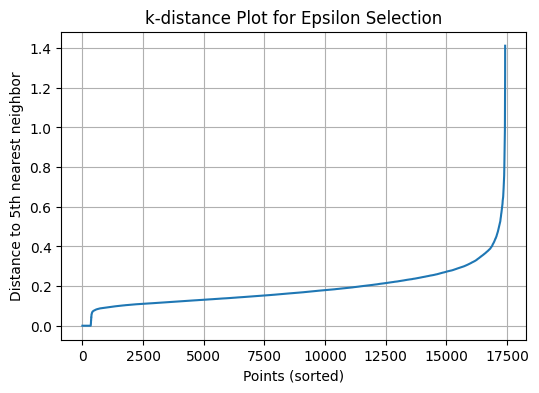

In [2]:
# We are trying to find the ideal value of epsilon in this block of code.

k = 5
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance Plot for Epsilon Selection")
plt.grid()
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

In [3]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

# Line between first and last point
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])

# Compute perpendicular distances
distances_to_line = np.abs(
    np.cross(point2 - point1, point1 - np.vstack((x, y)).T)
) / np.linalg.norm(point2 - point1)

# Elbow index
elbow_index = np.argmax(distances_to_line)
eps_optimal = k_distances[elbow_index]

print("Optimal epsilon value = ",eps_optimal)

Optimal epsilon value =  0.3306203218397205


In [6]:
reg = Ridge(alpha=1.0)

reg.fit(X, df['OT'])
df['OT_pred'] = reg.predict(X)

df['residual'] = df['OT'] - df['OT_pred']

median = np.median(df['residual'])
mad = np.median(np.abs(df['residual'] - median))
res_anomaly = np.abs(df['residual'] - median) > 3 * mad

In [7]:
clustering = DBSCAN(eps=eps_optimal, min_samples=5, metric='euclidean')
clustering.fit(X)
df['cluster'] = clustering.labels_

ot_threshold = df['OT'].quantile(0.85)   # top 15% of temperatures

# Physics-aware anomaly mask (high-OT only)
anomaly_mask = (df['cluster'] == -1) & (df['OT'] >= ot_threshold)

# noise statistics
dbscan_noise_count = (df['cluster'] == -1).sum()
dbscan_noise_ratio = np.mean(df['cluster'] == -1)

final_anomaly = (
    (df['cluster'] == -1) &
    (df['OT'] > ot_threshold) &
    res_anomaly
)

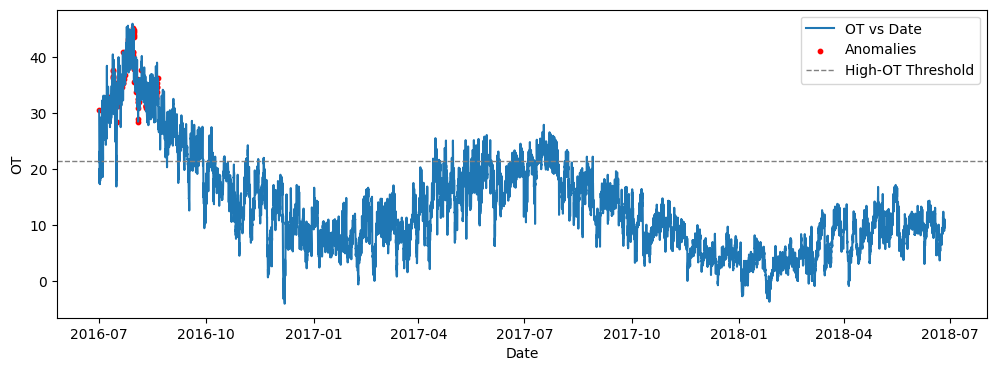

In [8]:
# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df['date'], df['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[final_anomaly, 'date'], df.loc[final_anomaly, 'OT'], color='red', s=10, label='Anomalies'
)

plt.axhline(
    ot_threshold,
    color='gray',
    linestyle='--',
    linewidth=1,
    label='High-OT Threshold'
)

plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

DBSCAN helps detect rare states

Ridge Regression helps detect unexpected responses

The "final_anomaly" basically identifies a rare operating point which also violates expected thermal behavior.

In [9]:
print("ANOMALY DETECTION RESULTS")

# DBSCAN statistics
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
print(f"\nDBSCAN Clustering:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {dbscan_noise_count} ({dbscan_noise_ratio*100:.2f}%)")

# Residual statistics
print(f"\nResidual Analysis:")
print(f"  Median residual: {median:.4f}")
print(f"  MAD: {mad:.4f}")
print(f"  Threshold (3×MAD): ±{3*mad:.4f}")
print(f"  High residual points: {res_anomaly.sum()} ({res_anomaly.mean()*100:.2f}%)")

# Final anomalies
print(f"\nFinal Anomalies (All criteria):")
print(f"  Count: {final_anomaly.sum()}")
print(f"  Percentage: {final_anomaly.mean()*100:.2f}%")

# Save for analysis
df[final_anomaly].to_csv('detected_anomalies.csv', index=False)
print(f"\nAnomalies saved to 'detected_anomalies.csv'")

ANOMALY DETECTION RESULTS

DBSCAN Clustering:
  Clusters found: 33
  Noise points: 607 (3.48%)

Residual Analysis:
  Median residual: -0.0001
  MAD: 0.0003
  Threshold (3×MAD): ±0.0010
  High residual points: 1201 (6.89%)

Final Anomalies (All criteria):
  Count: 103
  Percentage: 0.59%

Anomalies saved to 'detected_anomalies.csv'
